# Trabalho prático 2 - Realidade Aumentada
Vinicius Julião Ramos - 2018054630


Neste trabalho foi desenvolvido uma aplicação de realidade aumentada. A entrada do trabalho consite em três diferentes entidades, sendo elas:

1. Informação de calibração da câmera.
2. Um vídeo, no qual será projetado um objeto 3D do personagem Pikachu.
3. Uma imagem alvo, que será identificada no vídeo, para posicionamento da projeção do personagem Pikachu.

A estrutura deste trabalho foi construída em formato de um *pipeline* para que em cada *frame* do vídeo (1) colete-se a posição de cada imagem alvo, (2) calcule-se o posicionamento em 3 dimensões da imagem alvo, em relação à câmera e (3) exiba-se a imagem do Pikachu sobre os alvos, de maneira que o posicionamento em 3 dimensões do personagem, corresponda à cena daquele frame em questão. Portanto, a seguir, cada uma das etapas neccessárias nesse pipeline serão explicadas. Todas as bibliotecas utilizadas para a implementação desse trabalho são mostradas a seguir:

In [11]:
import cv2
import numpy as np
import pygame
import matplotlib.pyplot as plt
from OpenGL.GL import *
from PIL import Image
from OpenGL.GLUT import *
from OpenGL.GLU import *
from objloader import * # arquivo fornecido pelo professor

print("OpenGL:", OpenGL.__version__)
print("OpenCV:", cv2.__version__)
print("PIL:", Image.__version__)
print("pygame:",pygame.__version__)

## Passo 1 - Obtenção dos parâmetros intrissecos da câmera.

Apesar dos dados já estarem discriminados abaixo, os parâmetros intríssecos foram obtidos através do software Octave, versão 5.2, em conjunto com a biblioteca de calibração de câmera, disponiblizada em: [https://github.com/nghiaho12/camera_calibration_toolbox_octave](https://github.com/nghiaho12/camera_calibration_toolbox_octave). Para tal calibração, utilizou-se de 15 *frames* distintos do vídeo fornecido junto com a descrição do trabalho.

In [15]:
intrMat = np.float32([[416.7308, 0, 320.309], [0, 414.2021, 221.29132], [0, 0, 1]])
distVec = np.float32([0.08244, -0.0107, -0.00742, -0.011, 0.00000])

## Passo 2 - Detecção dos alvos e respectivas posições.

Apesar da estrutura geral deste trabalho consistir em um *pipeline*, optou-se por modularizar o código em pequenas funções, a fim de que distinguir os objetivos de cada etapa de tratamento da imagem. As saídas dos blocos de código a seguir foram extraídas do primeiro *frame* do vídeo fornecido juntamente com a descrição desse trabalho.

In [16]:
cap = cv2.VideoCapture('entrada.mp4')
ret, frame = cap.read()
cap.release()

As funções a seguir, auxiliam na remoção de ruídos do frame do vídeo. Como o alvo trata-se de uma imagem em preto e branco, elimina-se as informações desnecessárias (ruídos) como as cores do *frame* recebido como parâmetro das funções. Essa eliminação é feita em dois níveis diferentes, cada uma com a respectiva função:

* `getBinarizedImage(image)`: Recebe uma imagem colorida em RGB como entrada e retorna uma imagem com *pixels* binários. Para isso primeiro converte-se a imagem de colorido para a escala de cinza. Após a conversão em escala de cinza, transforma-se a imagem para binário de modo que é possível parametrizar o intervalo em escala de cinza no qual a chamada à `cv2.threshould` converterá cada pixel para branco ou preto.
* `getEdgedImage(binarizedImage)`: Como o alvo trata-se de uma imagem quadrada, utilizamos a conversão da imagem binarizada recebida na entrada, para produzir como saída uma imagem que destaque as bordas da imagem. Ou seja, sempre que a imagem houver uma transição entre bits vizinhos de branco para preto (ou vice e versa) haverá a formação de uma aresta. Sendo assim, nosso identificador do alvo terá mais facilidade em identificar os possíveis alvos.

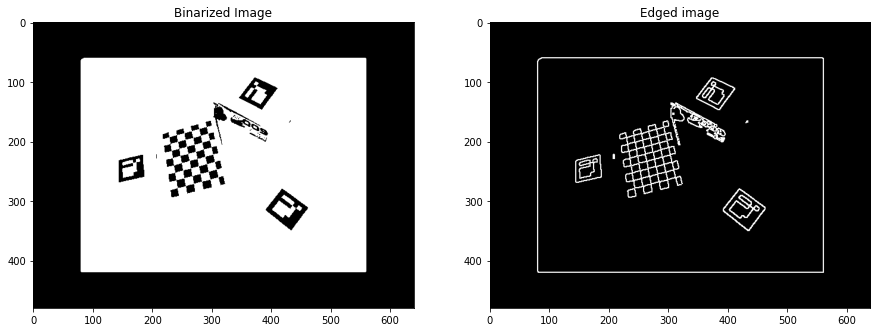

In [32]:
def getBinarizedImage(image):
    # to gray scale
    processedImg = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # binarize image
    _, processedImg = cv2.threshold(processedImg, 127, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return processedImg


def getEdgedImage(binarizedImage):
    # image canny detection
    edgedImg = cv2.Canny(binarizedImage, 100, 200)
    kernel = np.ones((2, 2))
    edgedImg = cv2.dilate(edgedImg, kernel, iterations=1)
    return edgedImg

binImage = getBinarizedImage(frame)
edgedImage = getEdgedImage(binImage)

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 2, 1)
ax.set_title("Binarized Image")
plt.imshow(binImage, cmap='gray')
bx = fig.add_subplot(1, 2, 2)
bx.set_title("Edged image")
plt.imshow(edgedImage, cmap='gray')
plt.show()


A partir de uma imagem binarizada ou então até mesmo uma imagem de bordas, a função a seguir é responsável por buscar os possíveis alvos no frame. Observe que neste ponto, ainda não há nenhum tipo de *matching* com o nosso alvo, apenas a identificação de polígonos, dadas as bordas dos objetos identificados numa imagem binarizada ou numa imagem de bordas.

* `getCandidateContours(edgedImg)`: recebe como parâmetro uma imagem de bordas ou então uma imagem binarizada, e retorna todos os contornos de com apenas 4 vértices (*corners*). Além disso, há um tratamento de identificação desses possíveis alvos, de maneira que só serão considerados aqueles que estão dentro de um intervalo da área mínima ou máxima do polígono. Também o contorno deve ser convexo, pois as possíveis transforações sofridas por um retêngulo projetado em 3D não farão surgir um plano em que se forme concavidades.

Assim, a imagem mostrada a seguir, demonstra os contornos candidatos a alvos. Neste caso, coincidentemente houve uma correnspondência com todos os alvos exibidos no *frame*. Entretanto, caso o limite de áre fosse relaxado, permitindo identificar retangulos maiores, o tabuleiro de xadres também surgiria como um candidato. Por isso, é necessário um certificado de *matching* do alvo, que será dado posteriormente.

3


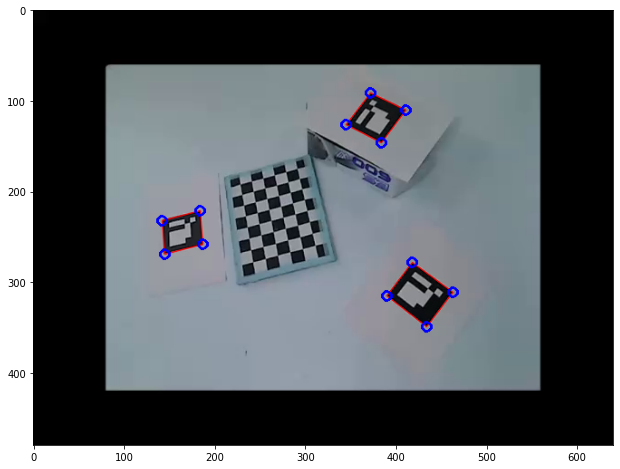

In [5]:
def getCandidateContours(edgedImg):
    
    contours, hierarchy = cv2.findContours(edgedImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    image_height, image_width = edgedImg.shape
    candidate_countours = []
    # The area of interest are those ones that fits at most 50% and at least 0.1% of the whole image
    maxArea = image_height*image_width*0.5
    minArea = image_height*image_width*0.001
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < maxArea and area > minArea:
            perimeter = cv2.arcLength(cnt, True)
            approx_polygon = cv2.approxPolyDP(cnt, 0.03 * perimeter, True)
            if (cv2.isContourConvex(approx_polygon) and len(approx_polygon) == 4):
                candidate_countours.append(approx_polygon)
                
    return candidate_countours


# contours = getCandidateContours(edgedImage)
contours = getCandidateContours(binImage)

print(len(contours))
image = frame.copy()
image = cv2.drawContours(image=image, contours=contours, contourIdx=-1,
                         color=(255, 0, 0), thickness=1, lineType=cv2.LINE_AA)
for cont in contours:
    for (i, p) in enumerate(cont):
        image = cv2.circle(image, tuple(p[0]), 5, color=(0, 0, 255), thickness=2)
plt.subplots(figsize=(15,8))
plt.imshow(image)
plt.show()

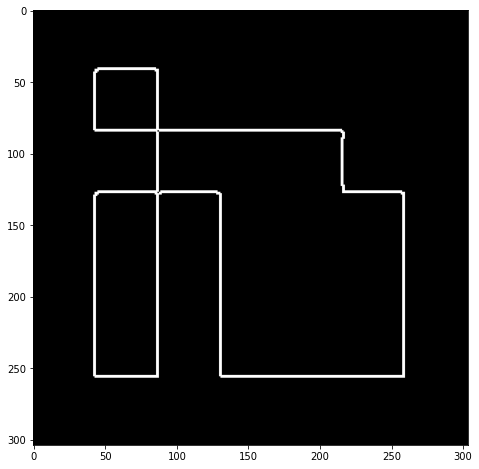

In [6]:
targetImg = cv2.imread("alvo.jpg")
edgedTargetImg = getEdgedImage(getBinarizedImage(targetImg))
plt.subplots(figsize=(15,8))
plt.imshow(edgedTargetImg, cmap='gray')
plt.show()

In [7]:
ROTATION_BAD = -1
ROTATION_0 = 0
ROTATION_90 = 1
ROTATION_180 = 2
ROTATION_270 = 3

def getBestRotation(projectionBinImg, targetBinImg):
    proj = projectionBinImg.copy()
    
    max_psnr = (-1,-1)
    for rotation_idx in [ROTATION_0, ROTATION_90, ROTATION_180, ROTATION_270]:
        max_psnr = max(max_psnr, (cv2.PSNR(targetBinImg, proj), rotation_idx))
        proj =  cv2.rotate(proj, cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    if(max_psnr[0] > 10): return max_psnr[1]
    return ROTATION_BAD    

def targetMatching(targetBinImg, sceneBinImg, contour):
    target_height, target_width = targetBinImg.shape
    target_corners = np.array([[0,0],
                               [target_width-1, 0],
                               [target_width-1, target_height-1],
                               [0, target_height-1]])
    homography_matrix, _ = cv2.findHomography(contour, target_corners, cv2.RANSAC, 5.0)
    projection = cv2.warpPerspective(sceneBinImg, homography_matrix, (target_width, target_height), flags=cv2.INTER_LINEAR)
    return getBestRotation(projection, targetBinImg)


def getPose(matchedContour, rotation=ROTATION_0):
    base3D = [[0,0,0], [1,0,0], [1,-1,0], [0,-1,0]]
    base_matrix_shift = rotation if rotation != ROTATION_90 else -rotation
    rotated3DBase = np.array(base3D[base_matrix_shift:]+base3D[:base_matrix_shift], dtype=np.float64)
    _, rotation, translation = cv2.solvePnP(rotated3DBase, matchedContour.astype(float), intrMat, distVec)
    return rotation, translation

def getPerspectiveMatrix(rotationMat, translationMat):
    rodr, _ = cv2.Rodrigues(rotationMat)
    perpectiveMat = np.append(rodr, translationMat, axis=1)
    perpectiveMat = np.append(perpectiveMat, [[0, 0, 0, 1]], axis=0)
    perpectiveMat[1:3, 0:4] *= -1
    return np.transpose(perpectiveMat).astype('float64')
    
# plt.subplots(figsize=(15,8))
# plt.imshow(projection, cmap='gray')
# targetMatching(getBinarizedImage(targetImg),getBinarizedImage(frame), contours[0])


1
[[-0.44298491 -0.80629426 -0.39198716  0.        ]
 [ 0.7639333  -0.56831109  0.30566063  0.        ]
 [-0.46922306 -0.164049    0.86770827  0.        ]
 [ 2.60910305 -1.64820329 -7.57677027  1.        ]]


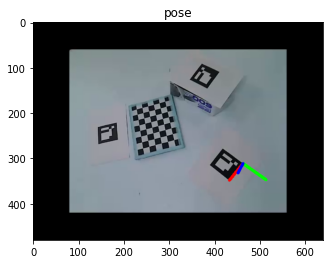

0


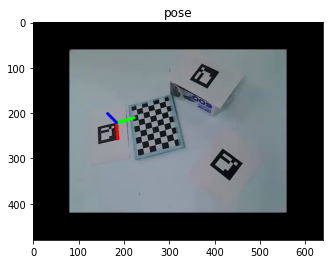

0


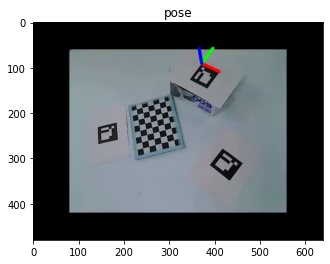

In [8]:
# TODO: DELETAR ESSE BLOCO

# https://docs.opencv.org/4.x/d7/d53/tutorial_py_pose.html
def draw(img, corner, projection):
    corner = tuple(corner.astype(int).ravel())
    img = cv2.line(img, corner, tuple(projection[0].astype(int).ravel()), (255,0,0), 5)
    img = cv2.line(img, corner, tuple(projection[1].astype(int).ravel()), (0,255,0), 5)
    img = cv2.line(img, corner, tuple(projection[2].astype(int).ravel()), (0,0,255), 5)
    return img

#https://docs.opencv.org/4.x/d7/d53/tutorial_py_pose.html
def draw_poses(sceneImg, rotation, contour, pose):
    image = sceneImg.copy()
    axis = np.float32([[1,0,0], [0,1,0], [0,0,1]])
    gray = cv2.cvtColor(sceneImg,cv2.COLOR_BGR2GRAY)
    proj, jacob = cv2.projectPoints(axis, pose[0], pose[1], intrMat, distVec)
    image = draw(image, contour[rotation], proj)
    plt.imshow(image, cmap='gray'),
    plt.title("pose")
    plt.show()

targetBinImg = getBinarizedImage(targetImg)
sceneBinImg = getBinarizedImage(frame)
rotationIdx = targetMatching(targetBinImg, sceneBinImg, contours[0])
pose = getPose(contours[0], rotation=rotationIdx)
print(rotationIdx)
print(getPerspectiveMatrix(pose[0], pose[1]))
draw_poses(frame, rotationIdx, contours[0], pose)

rotationIdx = targetMatching(targetBinImg, sceneBinImg, contours[1])
pose = getPose(contours[1], rotation=rotationIdx)
print(rotationIdx)
draw_poses(frame, rotationIdx, contours[1], pose)

rotationIdx = targetMatching(targetBinImg, sceneBinImg, contours[2])
pose = getPose(contours[2], rotation=rotationIdx)
print(rotationIdx)
draw_poses(frame, rotationIdx, contours[2], pose)

In [9]:
# errror

In [10]:


global pikachu_obj
pikachu_obj = None

def cameraAdjusts(width, height):
    fx = intrMat[0, 0]
    fy = intrMat[1, 1]
    fovy = 2 * np.arctan(0.5 * height / fy) * 180 / np.pi
    aspect = width * fy / (height * fx)
    gluPerspective(fovy, aspect, 0.1, 100.0)


def initOpenGL(dimensions):
    glClearColor(0.0, 0.0, 0.0, 0.0)
    glClearDepth(1.0)
    glEnable(GL_DEPTH_TEST)
    glMatrixMode(GL_PROJECTION)
    glLoadIdentity()
    
        
def object3D(viewMatrix):
    global pikachu_obj
    glPushMatrix()
    glLoadMatrixf(viewMatrix)
    

    glPushMatrix()
    glTranslatef(.5, .5, .25)
    glRotate(-90, 1, 0, 0)
    glutWireCone(.2,.8, 10, 6)
    glPopMatrix()
    
#     glTranslatef(.5, -.5, 0)
    glTranslatef(.2, -.25, 0)
    # renderiza um cubo
    glutWireCube(1.5)
    # renderiza o modelo do Pikachu
    glPushMatrix()
    glScalef(.4, .4, .4)
    glRotate(90, 0, 0, 1)
    glCallList(pikachu_obj.gl_list)
    glPopMatrix()
    glPopMatrix()

    

def background(backgroundImg):
    w, h = (640, 480)
    x, y = (0, 0)
    glBindTexture(GL_TEXTURE_2D, glGenTextures(1))
    glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_MIN_FILTER, GL_NEAREST)
    glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_MAG_FILTER, GL_NEAREST)
    glTexImage2D(GL_TEXTURE_2D, 0, GL_RGB, w, h, 0, GL_BGR, GL_UNSIGNED_BYTE, backgroundImg)

    glDepthMask(GL_FALSE)
    glMatrixMode(GL_PROJECTION)
    glLoadIdentity()
    glOrtho(0, w, h, 0.0, 0.0, 1)
    
    glEnable(GL_TEXTURE_2D)
    glBegin(GL_QUADS)
    
    for i, j in [(0, 0), (1, 0), (1, 1), (0, 1)]:
        glTexCoord2f(i, j)
        glVertex2f(x + w * i, y + h * j)

    glEnd()

    glBindTexture(GL_TEXTURE_2D, 0)
    glDepthMask(GL_TRUE)
    
    
def displayCallback():
    targetBinImg = getBinarizedImage(targetImg)
    sceneBinImg = getBinarizedImage(frame)
    extrissecMatrixes = []
    for cnt in contours:
        rotationIdx = targetMatching(targetBinImg, sceneBinImg, cnt)
        pose = getPose(cnt, rotation=rotationIdx)
        extrissecMatrixes.append(getPerspectiveMatrix(pose[0], pose[1]))
    
    
    glMatrixMode(GL_MODELVIEW)
    glLoadIdentity()
    glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)
    
    background(frame)
    
    # carregar o modelo 3D do Pikachu
    global pikachu_obj
    if pikachu_obj is None:
        pikachu_obj = OBJ("Pikachu.obj", swapyz=True)
    
    glMatrixMode(GL_PROJECTION)
    glLoadIdentity() 
    cameraAdjusts(640, 480)
    
    # habilita o uso de texturas (o Pikachu tem textura)
    glMatrixMode(GL_MODELVIEW)
    glLoadIdentity()
    glEnable(GL_TEXTURE_2D)
    for mat in extrissecMatrixes:
        object3D(mat)
        
    glutSwapBuffers()    
    

def idleCallback():
    glutPostRedisplay()


In [11]:
    
    
def init_open_gl():
    dimensions = (640, 480)
    glutInit()
    glutInitDisplayMode(GLUT_RGBA | GLUT_DOUBLE)
    glutSetOption(GLUT_ACTION_ON_WINDOW_CLOSE, GLUT_ACTION_CONTINUE_EXECUTION)
    glutInitWindowSize(*dimensions)
    window = glutCreateWindow(b'Realidade Aumentada [codigo esqueleto]')
    initOpenGL()
    
    
    glutDisplayFunc(displayCallback)
    glutIdleFunc(idleCallback)
    
    glutMainLoop()



In [12]:
init_open_gl()